In [ ]:
!nvidia-smi
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Fri Dec  5 11:30:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/LABS/equine_i3d/cropped_regions_50FPS.zip"
dest_dir = "/content/drive/MyDrive/LABS/equine_i3d/dataset"

# Create dataset dir if needed
import os
os.makedirs(dest_dir, exist_ok=True)

# Unzip
!unzip -q "{zip_path}" -d "{dest_dir}"

# Inspect
!ls "{dest_dir}"
!ls "{dest_dir}/cropped_regions_50FPS"

replace /content/drive/MyDrive/LABS/equine_i3d/dataset/cropped_regions_50FPS/S10_Video/chin/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: annotations.csv  cropped_regions_50FPS
S10_Video  S12_Video  S2_Video	S4_Video  S6_Video  S8_Video
S11_Video  S1_Video   S3_Video	S5_Video  S7_Video  S9_Video


In [ ]:
import os

root = "/content/drive/MyDrive/DL PROJECT/equine_i3d/dataset/cropped_regions_50FPS"
print("Video folders found:")
for name in sorted(os.listdir(root)):
    print(" -", name)


Video folders found:
 - S10_Video
 - S11_Video
 - S12_Video
 - S1_Video
 - S2_Video
 - S3_Video
 - S4_Video
 - S5_Video
 - S6_Video
 - S7_Video
 - S8_Video
 - S9_Video


In [ ]:
!ls "/content/drive/MyDrive/DL PROJECT/equine_i3d/dataset"
!ls "/content/drive/MyDrive/DL PROJECT/equine_i3d/dataset/cropped_regions_50FPS"

annotations.csv  cropped_regions_50FPS
S10_Video  S12_Video  S2_Video	S4_Video  S6_Video  S8_Video
S11_Video  S1_Video   S3_Video	S5_Video  S7_Video  S9_Video


In [ ]:
#  Install extra packages
!pip install tqdm seaborn opencv-python torchvision

In [ ]:
"""
PRODUCTION-READY EQUINE PAIN I3D PIPELINE
Fixed data leakage | Strong augmentation | Mixed precision | Gradient accumulation
Cross-validation + held-out test | Multi-region fusion
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GroupKFold
from torchvision import transforms
from torchvision.models.video import r3d_18
import random
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ==================== CONFIG ====================
class Config:
    # Base directory
    BASE_DIR = Path("/content/drive/MyDrive/DL PROJECT/equine_i3d")
    RIFE_CROPS_DIR  = BASE_DIR / "dataset" / "cropped_regions_50FPS"
    ANNOTATIONS_CSV = BASE_DIR / "dataset" / "annotations.csv"
    OUTPUT_DIR      = BASE_DIR / "final_results"
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    # Training
    BATCH_SIZE    = 8
    ACCUMULATION_STEPS = 4
    NUM_EPOCHS    = 60
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY  = 1e-5
    PATIENCE      = 10
    CLIP_LENGTH   = 16
    STRIDE        = 16
    NUM_WORKERS   = 2
    DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

    # Model
    REGIONS     = ["chin", "eye_left", "eye_right"]
    CLASS_NAMES = ["Mild", "Moderate"]

    # Video labels (0-indexed)
    VIDEO_PAIN_LEVELS = {
        'S1_Video': 1, 'S2_Video': 0, 'S3_Video': 1, 'S4_Video': 1, 'S5_Video': 1,
        'S6_Video': 0, 'S7_Video': 1, 'S8_Video': 1, 'S9_Video': 0, 'S10_Video': 1,
        'S11_Video': 1, 'S12_Video': 0,
    }

    @classmethod
    def compute_class_weights(cls):
        counts = np.bincount([cls.VIDEO_PAIN_LEVELS[v] for v in cls.VIDEO_PAIN_LEVELS])
        weights = counts.sum() / (counts.astype(float) + 1e-6)
        weights = weights / weights.mean()
        return torch.tensor(weights, dtype=torch.float)

# compute weights AFTER class definition
Config.CLASS_WEIGHTS = Config.compute_class_weights()

print("="*80)
print("EQUINE PAIN I3D PIPELINE INITIALIZED")
print("="*80)
print(f"Device: {Config.DEVICE}")
if Config.DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Effective batch size: {Config.BATCH_SIZE * Config.ACCUMULATION_STEPS}")
print("Class weights:", Config.CLASS_WEIGHTS.numpy().round(3))
print("RIFE crops dir exists:", Config.RIFE_CROPS_DIR.exists())
print("Annotations exists:", Config.ANNOTATIONS_CSV.exists())
print("="*80)


EQUINE PAIN I3D PIPELINE INITIALIZED
Device: cuda
GPU: Tesla T4
Effective batch size: 32
Class weights: [1.333 0.667]
RIFE crops dir exists: True
Annotations exists: True


In [ ]:
# ==================== DATASET ====================
class EquinePainDataset(Dataset):
    def __init__(self, root_dir, df, region, mode='train'):
        self.root_dir = Path(root_dir)
        self.region = region
        self.mode = mode
        # df is expected to have columns: video_name, pain_level
        self.df = df.reset_index(drop=True)
        self.clips = []
        self._build_index()

        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomResizedCrop(112, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
                transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(112),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])

    def _build_index(self):
        for _, row in self.df.iterrows():
            video = row['video_name']
            label = row['pain_level']
            path = self.root_dir / video / self.region
            if not path.exists():
                continue
            frames = sorted(path.glob("*.jpg"))
            if len(frames) < Config.CLIP_LENGTH:
                continue
            for i in range(0, len(frames) - Config.CLIP_LENGTH + 1, Config.STRIDE):
                self.clips.append({
                    'frames': frames[i:i + Config.CLIP_LENGTH],
                    'label': label,
                    'video': video
                })
        print(f"  {self.mode.upper():<5} {self.region:10}: {len(self.clips):4d} clips")

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        item = self.clips[idx]
        frames = [cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
                  for p in item['frames']]
        frames = [self.transform(f) for f in frames]
        clip = torch.stack(frames)   # [T, C, H, W], T=16

        if self.mode == 'train':
            # Temporal reverse
            if random.random() < 0.5:
                clip = clip.flip(0)

            # Simple temporal speed jitter, then resample back to 16
            if random.random() < 0.5:
                speed = random.choice([0.9, 1.1])
                new_len = max(8, min(24, int(clip.size(0) * speed)))  # vary length a bit
                # sample indices in [0, T-1]
                idxs = torch.linspace(0, clip.size(0) - 1, new_len).round().long()
                idxs = idxs.clamp(0, clip.size(0) - 1)
                clip = clip[idxs]  # [new_len, C, H, W]
                # resample back to exactly 16 frames
                idxs2 = torch.linspace(0, clip.size(0) - 1, 16).round().long()
                idxs2 = idxs2.clamp(0, clip.size(0) - 1)
                clip = clip[idxs2]  # [16, C, H, W]

        # Return as [C, T, H, W]
        return clip.permute(1, 0, 2, 3), item['label'], item['video']


In [ ]:
# ==================== MODEL ====================
class I3D_EquinePain(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        backbone = r3d_18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-1])  # drop final fc
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)          # [B, 512, 1, 1, 1]
        x = x.mean([2, 3, 4])         # [B, 512]
        return self.fc(x)             # [B, num_classes]


In [ ]:
# ==================== TRAINING WITH AMP + GRAD ACCUM ====================
def train_model(region, train_df, val_df, fold_name="final"):
    train_ds = EquinePainDataset(Config.RIFE_CROPS_DIR, train_df, region, 'train')
    val_ds   = EquinePainDataset(Config.RIFE_CROPS_DIR, val_df,   region, 'val')

    train_loader = DataLoader(
        train_ds, batch_size=Config.BATCH_SIZE, shuffle=True,
        num_workers=Config.NUM_WORKERS, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=Config.BATCH_SIZE, shuffle=False,
        num_workers=Config.NUM_WORKERS, pin_memory=True
    )

    model = I3D_EquinePain(num_classes=len(Config.CLASS_NAMES)).to(Config.DEVICE)
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY
    )
    criterion = nn.CrossEntropyLoss(weight=Config.CLASS_WEIGHTS.to(Config.DEVICE))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    scaler = GradScaler()

    best_f1 = 0.0
    patience = 0

    # NEW: history dict
    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_f1": []}

    print(f"\nTraining {region.upper()} model ({fold_name})")

    for epoch in range(1, Config.NUM_EPOCHS + 1):
        model.train()
        optimizer.zero_grad()
        running_loss = 0.0
        n_batches = 0

        # ------- TRAIN -------
        for i, (clips, labels, _) in enumerate(train_loader):
            clips = clips.to(Config.DEVICE)
            labels = labels.to(Config.DEVICE)

            with autocast():
                outputs = model(clips)
                loss = criterion(outputs, labels) / Config.ACCUMULATION_STEPS

            scaler.scale(loss).backward()

            if (i + 1) % Config.ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * Config.ACCUMULATION_STEPS
            n_batches += 1

        train_loss = running_loss / max(1, n_batches)

        # ------- VALIDATION -------
        model.eval()
        preds, trues = [], []
        val_loss_sum = 0.0
        val_batches = 0
        with torch.no_grad():
            for clips, labels, _ in val_loader:
                clips = clips.to(Config.DEVICE)
                labels = labels.to(Config.DEVICE)
                with autocast():
                    outputs = model(clips)
                    loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                val_batches += 1
                preds.extend(outputs.argmax(1).cpu().numpy())
                trues.extend(labels.cpu().numpy())

        val_loss = val_loss_sum / max(1, val_batches)
        val_f1 = f1_score(trues, preds, average='macro') if len(set(trues)) > 1 else 0.0

        scheduler.step(val_f1)

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        if val_f1 > best_f1 + 0.005:
            best_f1 = val_f1
            patience = 0
            torch.save(
                model.state_dict(),
                Config.OUTPUT_DIR / f"best_{region}_{fold_name}.pth"
            )
        else:
            patience += 1
            if patience >= Config.PATIENCE:
                print(f"  Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 1 or epoch == 1:
            print(f"  Epoch {epoch:02d} | "
                  f"Train Loss: {train_loss:.3f} | "
                  f"Val Loss: {val_loss:.3f} | "
                  f"Val F1: {val_f1:.3f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    print(f"  Best {region} F1: {best_f1:.3f}")
    return best_f1, pd.DataFrame(history)

In [16]:
# ==================== STRATIFIED FOLDS (VIDEO-LEVEL) ====================
def create_stratified_folds():
    """
    Manually define 5 folds so each validation split has both classes (Mild, Moderate).
    """
    folds = [
        {'train': ['S3_Video', 'S5_Video', 'S7_Video', 'S8_Video', 'S10_Video', 'S11_Video', 'S2_Video', 'S12_Video'],
         'val':   ['S1_Video', 'S6_Video']},
        {'train': ['S1_Video', 'S5_Video', 'S7_Video', 'S8_Video', 'S10_Video', 'S11_Video', 'S6_Video', 'S12_Video'],
         'val':   ['S3_Video', 'S2_Video']},
        {'train': ['S1_Video', 'S3_Video', 'S7_Video', 'S8_Video', 'S10_Video', 'S11_Video', 'S2_Video', 'S6_Video'],
         'val':   ['S5_Video', 'S9_Video']},
        {'train': ['S1_Video', 'S3_Video', 'S5_Video', 'S8_Video', 'S10_Video', 'S11_Video', 'S9_Video', 'S12_Video'],
         'val':   ['S7_Video', 'S6_Video']},
        {'train': ['S1_Video', 'S3_Video', 'S5_Video', 'S7_Video', 'S10_Video', 'S11_Video', 'S2_Video', 'S9_Video'],
         'val':   ['S8_Video', 'S12_Video']},
    ]
    return folds


In [17]:
# ==================== MAIN PIPELINE (STRATIFIED CV + TEST) ====================
def main():
    print("\nSTARTING FULL PIPELINE\n")

    # Held-out test set (balanced)
    test_videos = ['S2_Video', 'S4_Video', 'S7_Video']  # 1 Mild, 2 Moderate
    cv_videos = [v for v in Config.VIDEO_PAIN_LEVELS if v not in test_videos]

    cv_df = pd.DataFrame([
        {'video_name': v, 'pain_level': Config.VIDEO_PAIN_LEVELS[v]}
        for v in cv_videos
    ])
    test_df = pd.DataFrame([
        {'video_name': v, 'pain_level': Config.VIDEO_PAIN_LEVELS[v]}
        for v in test_videos
    ])

    # For later visualization: per-fold, per-region F1
    cv_f1_records = []

    # 5-fold STRATIFIED CV over videos (no leakage)
    print("5-FOLD STRATIFIED CROSS-VALIDATION")
    folds = create_stratified_folds()
    cv_scores = []

    for fold_idx, fold in enumerate(folds, 1):
        print(f"\nFold {fold_idx}/5")

        train_df = pd.DataFrame([
            {'video_name': v, 'pain_level': Config.VIDEO_PAIN_LEVELS[v]}
            for v in fold['train']
        ])
        val_df = pd.DataFrame([
            {'video_name': v, 'pain_level': Config.VIDEO_PAIN_LEVELS[v]}
            for v in fold['val']
        ])

        # Show validation videos and labels
        print("  Validation videos and labels:")
        for _, row in val_df.iterrows():
            print(f"    {row['video_name']}: {Config.CLASS_NAMES[row['pain_level']]}")

        print("  Validation class counts:")
        counts = val_df['pain_level'].value_counts().to_dict()
        for cls_idx, name in enumerate(Config.CLASS_NAMES):
            print(f"    {name}: {counts.get(cls_idx, 0)}")

        # Train per region, collect only F1 from train_model
        fold_f1s = []
        for r in Config.REGIONS:
            best_f1, _ = train_model(r, train_df, val_df, f"fold{fold_idx}")
            fold_f1s.append(best_f1)
            cv_f1_records.append({'fold': fold_idx, 'region': r, 'f1': best_f1})

        mean_f1 = np.mean(fold_f1s)
        print(f"  Fold {fold_idx} mean F1 across regions: {mean_f1:.3f}")
        cv_scores.append(mean_f1)

    # Save CV F1 info for plotting later
    cv_f1_df = pd.DataFrame(cv_f1_records)
    cv_f1_df.to_csv(Config.OUTPUT_DIR / "cv_f1_per_fold.csv", index=False)

    print(f"\nCV Mean F1: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

    # ================= FINAL TRAINING + TEST EVAL =================
    print("\nFINAL TEST EVALUATION")
    models = {}
    final_histories = []

    for region in Config.REGIONS:
        # train on all 9 CV videos (cv_df), get full history
        best_f1, hist = train_model(region, cv_df, cv_df, "final")
        hist["region"] = region
        final_histories.append(hist)

        model = I3D_EquinePain(num_classes=len(Config.CLASS_NAMES)).to(Config.DEVICE)
        model.load_state_dict(torch.load(
            Config.OUTPUT_DIR / f"best_{region}_final.pth",
            map_location=Config.DEVICE
        ))
        model.eval()
        models[region] = model

    # Save final training history (for loss/F1 curves)
    final_hist_df = pd.concat(final_histories, ignore_index=True)
    final_hist_df.to_csv(Config.OUTPUT_DIR / "final_training_history.csv", index=False)

    # Multi-region fusion on test set
    video_probs = {v: np.zeros(len(Config.CLASS_NAMES)) for v in test_videos}
    for region, model in models.items():
        ds = EquinePainDataset(Config.RIFE_CROPS_DIR, test_df, region, 'val')
        loader = DataLoader(ds, batch_size=8, shuffle=False)
        with torch.no_grad():
            for clips, _, names in loader:
                clips = clips.to(Config.DEVICE)
                with autocast():
                    probs = torch.softmax(model(clips), dim=1).cpu().numpy()
                for n, p in zip(names, probs):
                    video_probs[n] += p
    for v in video_probs:
        video_probs[v] /= len(Config.REGIONS)

    # Collect results
    results = []
    for v in test_videos:
        pred = int(video_probs[v].argmax())
        true = Config.VIDEO_PAIN_LEVELS[v]
        results.append({
            'video': v,
            'true': Config.CLASS_NAMES[true],
            'pred': Config.CLASS_NAMES[pred],
            'correct': pred == true
        })

    df_results = pd.DataFrame(results)
    print("\nFINAL TEST RESULTS")
    print(df_results.to_string(index=False))

    Config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    df_results.to_csv(Config.OUTPUT_DIR / "final_test_results.csv", index=False)

    print(f"\nPipeline complete. Results saved to {Config.OUTPUT_DIR}")

    # Return for later plotting in notebook
    return cv_f1_df, df_results, final_hist_df

In [18]:
cv_f1_df, df_results, final_hist_df = main()



STARTING FULL PIPELINE

5-FOLD STRATIFIED CROSS-VALIDATION

Fold 1/5
  Validation videos and labels:
    S1_Video: Moderate
    S6_Video: Mild
  Validation class counts:
    Mild: 1
    Moderate: 1
  TRAIN chin      :  117 clips
  VAL   chin      :   16 clips

Training CHIN model (fold1)
  Epoch 01 | Train Loss: 0.682 | Val Loss: 0.615 | Val F1: 0.385 | LR: 1.00e-04
  Epoch 11 | Train Loss: 0.072 | Val Loss: 1.475 | Val F1: 0.273 | LR: 5.00e-05
  Early stopping at epoch 14
  Best chin F1: 0.543
  TRAIN eye_left  :  154 clips
  VAL   eye_left  :   45 clips

Training EYE_LEFT model (fold1)
  Epoch 01 | Train Loss: 0.649 | Val Loss: 0.688 | Val F1: 0.545 | LR: 1.00e-04
  Early stopping at epoch 11
  Best eye_left F1: 0.545
  TRAIN eye_right :  103 clips
  VAL   eye_right :   28 clips

Training EYE_RIGHT model (fold1)
  Epoch 01 | Train Loss: 0.771 | Val Loss: 0.739 | Val F1: 0.417 | LR: 1.00e-04
  Epoch 11 | Train Loss: 0.087 | Val Loss: 1.301 | Val F1: 0.417 | LR: 5.00e-05
  Early stopp

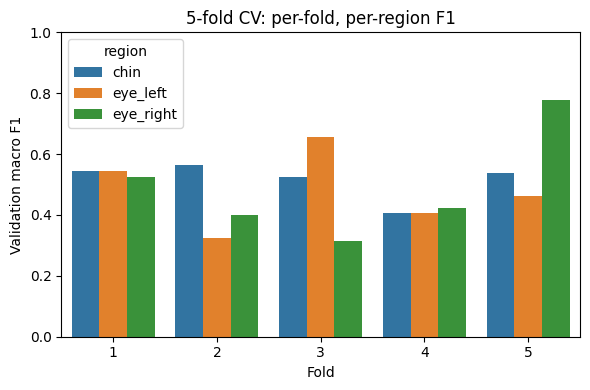

Confusion matrix (rows=true, cols=pred):
 [[0 1]
 [0 2]]


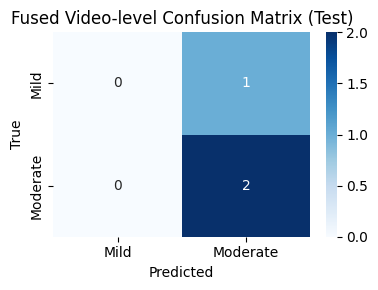

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Per-fold, per-region F1 bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=cv_f1_df, x='fold', y='f1', hue='region')
plt.ylim(0, 1.0)
plt.xlabel("Fold")
plt.ylabel("Validation macro F1")
plt.title("5-fold CV: per-fold, per-region F1")
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / "cv_f1_per_fold.png", dpi=150, bbox_inches="tight")
plt.show()

# 2) Confusion matrix for final fused test
true_labels = df_results['true'].map({c:i for i,c in enumerate(Config.CLASS_NAMES)}).values
pred_labels = df_results['pred'].map({c:i for i,c in enumerate(Config.CLASS_NAMES)}).values

cm = confusion_matrix(true_labels, pred_labels, labels=[0,1])
print("Confusion matrix (rows=true, cols=pred):\n", cm)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=Config.CLASS_NAMES,
    yticklabels=Config.CLASS_NAMES,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Fused Video-level Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / "confmat_fused_test.png", dpi=150, bbox_inches="tight")
plt.show()


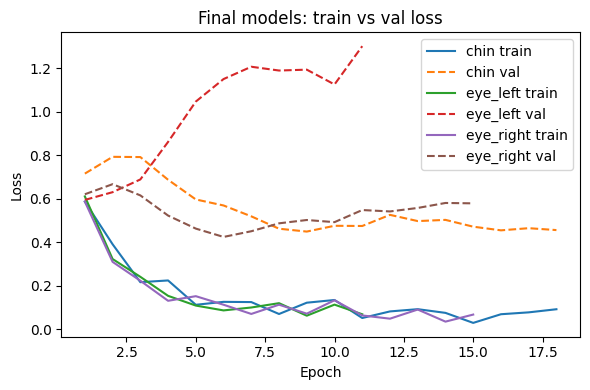

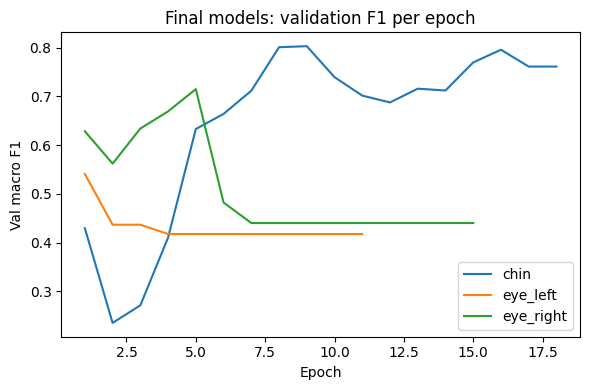

In [20]:
hist = pd.read_csv(Config.OUTPUT_DIR / "final_training_history.csv")

plt.figure(figsize=(6,4))
for region in Config.REGIONS:
    h = hist[hist["region"] == region]
    plt.plot(h["epoch"], h["train_loss"], label=f"{region} train")
    plt.plot(h["epoch"], h["val_loss"], linestyle="--", label=f"{region} val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final models: train vs val loss")
plt.legend()
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / "final_loss_curves.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
for region in Config.REGIONS:
    h = hist[hist["region"] == region]
    plt.plot(h["epoch"], h["val_f1"], label=region)
plt.xlabel("Epoch")
plt.ylabel("Val macro F1")
plt.title("Final models: validation F1 per epoch")
plt.legend()
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / "final_val_f1_curves.png", dpi=150, bbox_inches="tight")
plt.show()

### OLD

In [ ]:
# Run everything
main()


STARTING FULL PIPELINE

5-FOLD CROSS-VALIDATION

Fold 1/5
  TRAIN chin      :  103 clips
  VAL   chin      :   11 clips

Training CHIN model (fold1)
  Epoch 01 | Val F1: 0.353 | LR: 1.00e-04
  Epoch 11 | Val F1: 0.312 | LR: 5.00e-05
  Epoch 21 | Val F1: 0.267 | LR: 2.50e-05
  Early stopping at epoch 24
  Best chin F1: 0.476
  TRAIN eye_left  :  141 clips
  VAL   eye_left  :   32 clips

Training EYE_LEFT model (fold1)
  Epoch 01 | Val F1: 0.407 | LR: 1.00e-04
  Epoch 11 | Val F1: 0.407 | LR: 5.00e-05
  Early stopping at epoch 14
  Best eye_left F1: 0.506
  TRAIN eye_right :   85 clips
  VAL   eye_right :   27 clips

Training EYE_RIGHT model (fold1)
  Epoch 01 | Val F1: 0.400 | LR: 1.00e-04
  Epoch 11 | Val F1: 0.426 | LR: 5.00e-05
  Early stopping at epoch 15
  Best eye_right F1: 0.632

Fold 2/5
  TRAIN chin      :   78 clips
  VAL   chin      :   36 clips

Training CHIN model (fold2)
  Epoch 01 | Val F1: 0.390 | LR: 1.00e-04
  Early stopping at epoch 11
  Best chin F1: 0.390
  TRAIN e

In [ ]:
from sklearn.model_selection import GroupKFold
import pandas as pd
import numpy as np

test_videos = ['S2_Video', 'S4_Video', 'S7_Video']
cv_videos = [v for v in Config.VIDEO_PAIN_LEVELS if v not in test_videos]

cv_df = pd.DataFrame([
    {'video_name': v, 'pain_level': Config.VIDEO_PAIN_LEVELS[v]}
    for v in cv_videos
])

print("5-fold CV video / class distribution (no training):")
gkf = GroupKFold(n_splits=5)
for fold, (tr_idx, val_idx) in enumerate(
    gkf.split(cv_df, groups=cv_df['video_name']), 1
):
    val_df = cv_df.iloc[val_idx]
    print(f"\nFold {fold}")
    print("  Validation videos and labels:")
    for _, row in val_df.iterrows():
        print(f"    {row['video_name']}: {Config.CLASS_NAMES[row['pain_level']]}")
    print("  Validation class counts:")
    counts = val_df['pain_level'].value_counts().to_dict()
    for cls_idx, name in enumerate(Config.CLASS_NAMES):
        print(f"    {name}: {counts.get(cls_idx, 0)}")


5-fold CV video / class distribution (no training):

Fold 1
  Validation videos and labels:
    S1_Video: Moderate
    S9_Video: Mild
  Validation class counts:
    Mild: 1
    Moderate: 1

Fold 2
  Validation videos and labels:
    S8_Video: Moderate
    S12_Video: Mild
  Validation class counts:
    Mild: 1
    Moderate: 1

Fold 3
  Validation videos and labels:
    S6_Video: Mild
    S11_Video: Moderate
  Validation class counts:
    Mild: 1
    Moderate: 1

Fold 4
  Validation videos and labels:
    S5_Video: Moderate
    S10_Video: Moderate
  Validation class counts:
    Mild: 0
    Moderate: 2

Fold 5
  Validation videos and labels:
    S3_Video: Moderate
  Validation class counts:
    Mild: 0
    Moderate: 1


In [ ]:
def extract_i3d_features(region, df, split_name="all_videos"):
    """
    Extract video-level I3D features for a given region and list of videos.
    Saves a NumPy array per video in OUTPUT_DIR/i3d_features/<region>/.
    """
    print(f"\n[FEATURES] Region: {region} | Split: {split_name}")

    # 1) Load trained final model for this region
    ckpt_path = Config.OUTPUT_DIR / f"best_{region}_final.pth"
    assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"

    model = I3D_EquinePain(num_classes=len(Config.CLASS_NAMES)).to(Config.DEVICE)
    state = torch.load(ckpt_path, map_location=Config.DEVICE)
    model.load_state_dict(state)
    model.eval()

    # Remove final FC layer to get 512-D features
    feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(Config.DEVICE)

    # 2) Dataset and loader over the requested videos
    ds = EquinePainDataset(Config.RIFE_CROPS_DIR, df, region, mode='val')
    loader = DataLoader(ds, batch_size=8, shuffle=False, num_workers=Config.NUM_WORKERS)

    # 3) Aggregate clip-level features per video
    video_feats = {}
    with torch.no_grad():
        for clips, _, names in tqdm(loader, desc=f"Extract {region}", ncols=100):
            clips = clips.to(Config.DEVICE)
            feats = feature_extractor(clips)              # [B, 512]
            feats = feats.mean(dim=0, keepdim=True)       # simple average per batch
            feats = feats.cpu().numpy()

            # Because loader batches clips from multiple videos, do it per item
            clips = clips.cpu()  # just for names loop length
            for i, vname in enumerate(names):
                # Re-compute feature per sample to avoid mixing videos
                clip_i = clips[i : i+1].to(Config.DEVICE)
                with torch.no_grad():
                    f_i = feature_extractor(clip_i).squeeze(0).cpu().numpy()  # [512]

                if vname not in video_feats:
                    video_feats[vname] = []
                video_feats[vname].append(f_i)

    # 4) Average features over all clips of each video and save
    out_dir = Config.OUTPUT_DIR / "i3d_features" / region
    out_dir.mkdir(parents=True, exist_ok=True)

    for vname, feat_list in video_feats.items():
        feat_arr = np.stack(feat_list, axis=0).mean(axis=0)  # [512]
        out_path = out_dir / f"{vname}_feat.npy"
        np.save(out_path, feat_arr)
        print(f"  Saved {vname} → {out_path}")


In [ ]:
all_df = pd.DataFrame([
    {'video_name': v, 'pain_level': Config.VIDEO_PAIN_LEVELS[v]}
    for v in Config.VIDEO_PAIN_LEVELS
])
all_df


,video_name,pain_level
0,S1_Video,1
1,S2_Video,0
2,S3_Video,1
3,S4_Video,1
4,S5_Video,1
5,S6_Video,0
6,S7_Video,1
7,S8_Video,1
8,S9_Video,0
9,S10_Video,1


In [ ]:
print("\n" + "="*80)
print("STARTING I3D FEATURE EXTRACTION (USING FINAL MODELS)")
print("="*80)

for region in Config.REGIONS:
    extract_i3d_features(region, all_df, split_name="all_videos")

print("\nI3D FEATURE EXTRACTION COMPLETE!")
print("Features saved in:", Config.OUTPUT_DIR / "i3d_features")



STARTING I3D FEATURE EXTRACTION (USING FINAL MODELS)

[FEATURES] Region: chin | Split: all_videos
  VAL   chin      :  160 clips


Extract chin: 100%|█████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


  Saved S1_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S1_Video_feat.npy
  Saved S2_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S2_Video_feat.npy
  Saved S3_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S3_Video_feat.npy
  Saved S4_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S4_Video_feat.npy
  Saved S5_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S5_Video_feat.npy
  Saved S6_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S6_Video_feat.npy
  Saved S7_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S7_Video_feat.npy
  Saved S8_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S8_Video_feat.npy
  Saved S9_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/chin/S9_Video_feat.npy
  Saved S10_Video → /content

Extract eye_left: 100%|█████████████████████████████████████████████| 28/28 [00:22<00:00,  1.22it/s]


  Saved S1_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S1_Video_feat.npy
  Saved S2_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S2_Video_feat.npy
  Saved S3_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S3_Video_feat.npy
  Saved S4_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S4_Video_feat.npy
  Saved S5_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S5_Video_feat.npy
  Saved S6_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S6_Video_feat.npy
  Saved S7_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S7_Video_feat.npy
  Saved S8_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S8_Video_feat.npy
  Saved S9_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_left/S9_Video_f

Extract eye_right: 100%|████████████████████████████████████████████| 18/18 [00:14<00:00,  1.23it/s]

  Saved S1_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S1_Video_feat.npy
  Saved S2_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S2_Video_feat.npy
  Saved S3_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S3_Video_feat.npy
  Saved S4_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S4_Video_feat.npy
  Saved S5_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S5_Video_feat.npy
  Saved S6_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S6_Video_feat.npy
  Saved S7_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S7_Video_feat.npy
  Saved S8_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S8_Video_feat.npy
  Saved S9_Video → /content/drive/MyDrive/LABS/equine_i3d/final_results/i3d_features/eye_right/S

In [ ]:
df_results = pd.DataFrame(results)
# columns: video, true